In [1]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)

from sklearn.externals import joblib
loaded_model = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting.pkl'))
loaded_model_2 = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC.pkl'))

loaded_model_A = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_A.pkl'))
loaded_model_B = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_B.pkl'))
loaded_model_D = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_D.pkl'))
loaded_model_E = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_E.pkl'))
loaded_model_F = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_F.pkl'))
loaded_model_F_noDR = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_F_noDR.pkl'))

loaded_model_opt = joblib.load(os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_optimized.pkl'))

print loaded_model_F


Welcome to ROOTaaS 6.05/02
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1e-05, missing=nan, n_estimators=1500, nthread=20,
       objective='multi:softprob', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [2]:
ntuples = '20170526'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
diphotonJets = [s for s in files if "DiPhotonJets" in s]
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1)
utils.IO.add_background(ntuples,diphotonJets,-1)
utils.IO.add_background(ntuples,gJets_lowPt,-2)
utils.IO.add_background(ntuples,gJets_highPt,-2)

for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526
using background file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/AllNonResSig_20170526.root


In [3]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,DiJetDiPho_DR'.split(",")
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
#branch_names = (b.replace(" ", "_") for b in branch_names)
#branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

#utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
#utils.IO.w_sig.append(utils.IO.get_weight('signal','nrSM',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','DiPhoJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',1))


preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
#weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = preprocessing.randomize(X_sig,y_sig,weights_sig)

print X_bkg.shape
print y_bkg.shape
#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig)
print X_bkg.shape
print y_bkg.shape

y_total_train = preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()

['leadingJet_bDis', 'subleadingJet_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M()', 'noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'DiJetDiPho_DR']
(2254174, 13)
(2254174, 1)
(1922962, 13)
(1922962, 1)


In [5]:
import matplotlib.pyplot as plt

fpr_gJ,tpr_gJ = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model,-2,outString="xgbr_gJets_resWeighting",weights=w_total_test)
fpr_gJ_2,tpr_gJ_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_2,-2,outString="xgbr_gJets",weights=w_total_test)

fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model,-1,outString="xgbr_diphotons_resWeighting",weights=w_total_test)
fpr_dipho_2,tpr_dipho_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_2,-1,outString="xgbr_diphotons",weights=w_total_test)


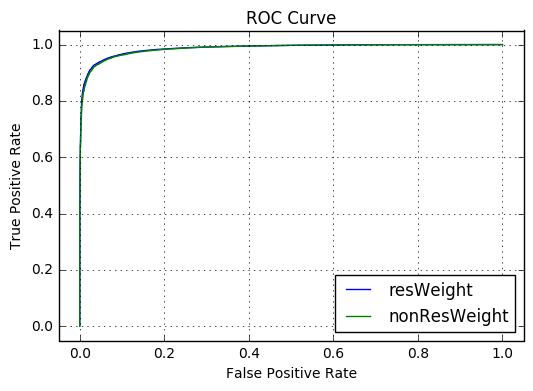

In [7]:
plt.plot(fpr_gJ, tpr_gJ, lw=1, label='resWeight')

plt.plot(fpr_gJ_2, tpr_gJ_2, lw=1, label='nonResWeight')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_resWeight"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")

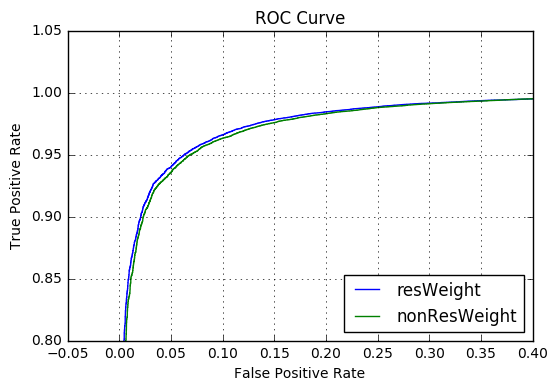

In [8]:
plt.plot(fpr_gJ, tpr_gJ, lw=1, label='resWeight')

plt.plot(fpr_gJ_2, tpr_gJ_2, lw=1, label='nonResWeight')



plt.xlim([-0.05, 0.4])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_resWeight_zoom"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")

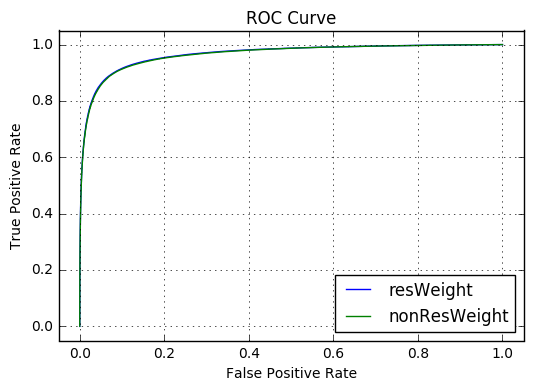

In [9]:
plt.plot(fpr_dipho, tpr_dipho, lw=1, label='resWeight')

plt.plot(fpr_dipho_2, tpr_dipho_2, lw=1, label='nonResWeight')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_resWeight_dipho"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")

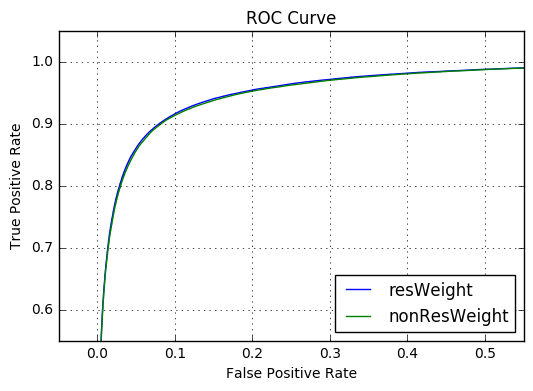

In [10]:
plt.plot(fpr_dipho, tpr_dipho, lw=1, label='resWeight')

plt.plot(fpr_dipho_2, tpr_dipho_2, lw=1, label='nonResWeight')



plt.xlim([-0.05, 0.55])
plt.ylim([0.55, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_resWeight_dipho_zoom"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")

In [11]:
fpr_gJ_A,tpr_gJ_A = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_A,-2,outString="xgbr_gJets_w",weights=w_total_test)
fpr_dipho_A,tpr_dipho_A = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_A,-1,outString="xgbr_diphotons",weights=w_total_test)
#plotting.print_roc_report(fpr_dipho_A,tpr_dipho_A,step=0.05)

In [5]:
fpr_gJ_B,tpr_gJ_B = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_B,-2,outString="xgbr_gJets_w",weights=w_total_test)
fpr_dipho_B,tpr_dipho_B = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_B,-1,outString="xgbr_diphotons",weights=w_total_test)
#plotting.print_roc_report(fpr_dipho_B,tpr_dipho_B,step=0.05)

In [6]:
fpr_gJ_D,tpr_gJ_D = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_D,-2,outString="xgbr_gJets_w",weights=w_total_test)
fpr_dipho_D,tpr_dipho_D = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_D,-1,outString="xgbr_diphotons",weights=w_total_test)
#plotting.print_roc_report(fpr_dipho_D,tpr_dipho_D,step=0.05)

In [7]:
fpr_gJ_E,tpr_gJ_E = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_E,-2,outString="xgbr_gJets_w",weights=w_total_test)
fpr_dipho_E,tpr_dipho_E = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_E,-1,outString="xgbr_diphotons",weights=w_total_test)

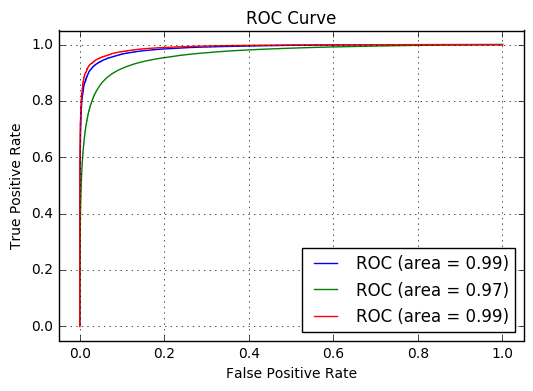

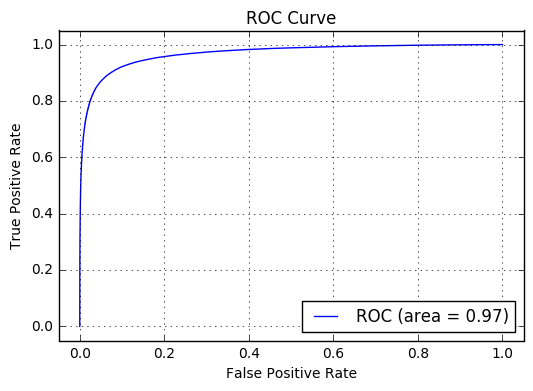

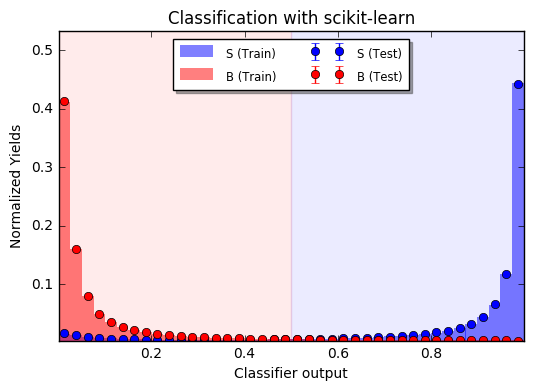

In [12]:
fpr_gJ_F,tpr_gJ_F = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_F,-2,outString="xgbr_gJets_resWeight_optimized_F",weights=w_total_test)
plt.show()
fpr_dipho_F,tpr_dipho_F = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_F,-1,outString="xgbr_diphotonsresWeight_optimized_F",weights=w_total_test)
plt.show()
plotting.plot_classifier_output(loaded_model_F,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg_resWeight_optimized_F")
plt.show()

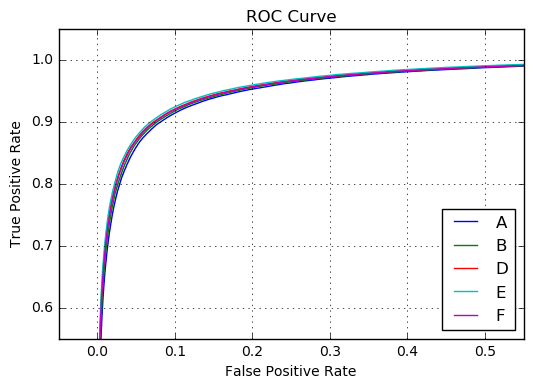

In [11]:
import matplotlib.pyplot as plt

plt.plot(fpr_dipho_A, tpr_dipho_A, lw=1, label='A')
plt.plot(fpr_dipho_B, tpr_dipho_B, lw=1, label='B')
plt.plot(fpr_dipho_D, tpr_dipho_D, lw=1, label='D')
plt.plot(fpr_dipho_E, tpr_dipho_E, lw=1, label='E')
plt.plot(fpr_dipho_F, tpr_dipho_F, lw=1, label='F')


plt.xlim([-0.05, 0.55])
plt.ylim([0.55, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_resWeight_optimization_dipho_zoom"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")

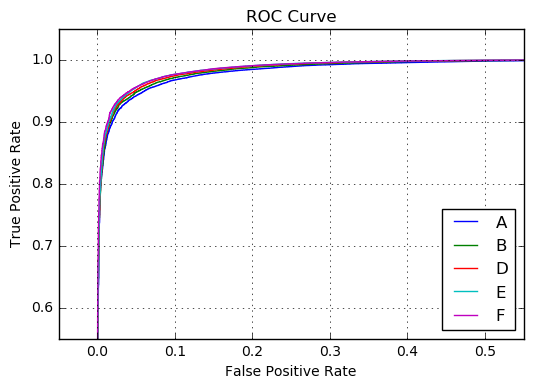

In [15]:
plt.plot(fpr_gJ_A, tpr_gJ_A, lw=1, label='A')
plt.plot(fpr_gJ_B, tpr_gJ_B, lw=1, label='B')
plt.plot(fpr_gJ_D, tpr_gJ_D, lw=1, label='D')
plt.plot(fpr_gJ_E, tpr_gJ_E, lw=1, label='E')
plt.plot(fpr_gJ_F, tpr_gJ_F, lw=1, label='F')


plt.xlim([-0.05, 0.55])
plt.ylim([0.55, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_resWeight_optimization_gJ_zoom"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")

In [10]:
###########re-running after removing DR from branch_names########################

#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr'.split(",")
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
#branch_names = (b.replace(" ", "_") for b in branch_names)
#branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

#utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
#utils.IO.w_sig.append(utils.IO.get_weight('signal','nrSM',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','DiPhoJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',1))


preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
#weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = preprocessing.randomize(X_sig,y_sig,weights_sig)

print X_bkg.shape
print y_bkg.shape
#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig)
print X_bkg.shape
print y_bkg.shape

y_total_train = preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()


['leadingJet_bDis', 'subleadingJet_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M()', 'noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr']
(2254174, 12)
(2254174, 1)
(1922962, 12)
(1922962, 1)


In [14]:
fpr_gJ_F_noDR,tpr_gJ_F_noDR = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_F_noDR,-2,outString="xgbr_gJets_resWeight_optimized_F_noDR",weights=w_total_test)
fpr_dipho_F_noDR,tpr_dipho_F_noDR = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,loaded_model_F_noDR,-1,outString="xgbr_diphotonsresWeight_optimized_F_noDR",weights=w_total_test)

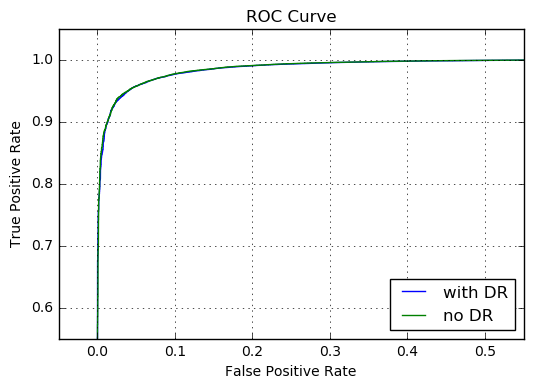

In [19]:
plt.plot(fpr_gJ_F, tpr_gJ_F, lw=1, label='with DR')
plt.plot(fpr_gJ_F_noDR, tpr_gJ_F_noDR, lw=1, label='no DR')


plt.xlim([-0.05, 0.55])
plt.ylim([0.55, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_gJ_noDR"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")

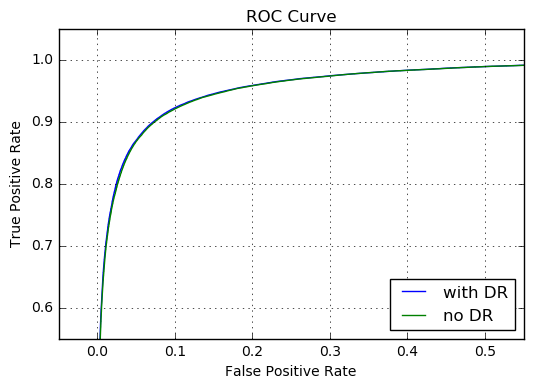

In [20]:
plt.plot(fpr_dipho_F, tpr_dipho_F, lw=1, label='with DR')
plt.plot(fpr_dipho_F_noDR, tpr_dipho_F_noDR, lw=1, label='no DR')


plt.xlim([-0.05, 0.55])
plt.ylim([0.55, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()

plt.show()

outString = "comparison_dipho_noDR"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")